In [13]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
from typing import Dict, Any

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 250

# change working directory to project root
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../..')
from experiments.notebooks import viz
from experiments.util import get_clean_dataset

def get_comparison_result(path: str, estimator_name: str, test=False) -> Dict[str, Any]:
    if test:
        result_file = path + 'test/' + f'{estimator_name}_test_comparisons.pkl'
    else:
        result_file = path + 'val/' + f'{estimator_name}_comparisons.pkl'
    return pkl.load(open(result_file, 'rb'))    
    
MODEL_COMPARISON_PATH = 'experiments/comparison_data/'

datasets = [
        ("breast-cancer", 13),
        ("breast-w", 15),
        ("credit-g", 31),
        ("haberman", 43),
        ("heart", 1574),
        ("labor", 4),
        ("vote", 56),
    
    ]
from experiments.config.config import HARD_DATASETS
# HARD_DATASETS = [
#     ("recidivism", DATASET_PATH + "compas-analysis/compas_two_year_clean.csv"),
#     ("credit", DATASET_PATH + "credit_card/UCI_Credit_Card.csv"),
#     ("juvenile", DATASET_PATH + "ICPSR_03986/DS0001/data_clean.csv")
# ]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# dataset stats

In [37]:
metadata = []
columns = ['Name', 'Samples', 'Features', 'Class 0', 'Class 1', 'Majority class %']
for dataset_name, data_id in datasets + HARD_DATASETS:
    try:
        if dataset_name in HARD_DATASETS:
            X, y = get_clean_dataset(data_id)
        else:
            dataset = fetch_openml(data_id=data_id, as_frame=False)
            X, y = dataset.data, dataset.target
        shape = X.shape
        class_counts = np.unique(y, return_counts=True)[1]
        metadata.append([dataset_name.capitalize(), shape[0], shape[1], class_counts[0], class_counts[1],
                         np.round(100 * np.max(class_counts) / np.sum(class_counts), decimals=1)])
    except Exception as e:
        print(e)
        print('skipped', dataset_name)
metadata = pd.DataFrame(metadata, columns=columns) #.set_index('Name')

Dataset with data_id /accounts/projects/vision/chandan/imodels/experiments/data/compas-analysis/compas_two_year_clean.csv not found.
skipped recidivism
Dataset with data_id /accounts/projects/vision/chandan/imodels/experiments/data/credit_card/UCI_Credit_Card.csv not found.
skipped credit
Dataset with data_id /accounts/projects/vision/chandan/imodels/experiments/data/ICPSR_03986/DS0001/data_clean.csv not found.
skipped juvenile


In [38]:
print(metadata.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
         Name &  Samples &  Features &  Class 0 &  Class 1 &  Majority class \% \\
\midrule
Breast-cancer &      286 &         9 &      201 &       85 &              70.3 \\
     Breast-w &      699 &         9 &      458 &      241 &              65.5 \\
     Credit-g &     1000 &        20 &      300 &      700 &              70.0 \\
     Haberman &      306 &         3 &      225 &       81 &              73.5 \\
        Heart &      270 &        13 &      150 &      120 &              55.6 \\
        Labor &       57 &        16 &       20 &       37 &              64.9 \\
         Vote &      435 &        16 &      267 &      168 &              61.4 \\
\bottomrule
\end{tabular}



In [4]:
test_models = [
    'random_forest', 
    'gradient_boosting', 
    'skope_rules', 
    'rulefit', 
    'brl',
    'grl',
    'oner',
    'brs',
    'fplasso', 
    'fpskope',    
    'stbl_l2_mm0',
    'stbl_l2_mm1', 
    'stbl_l2_mm2'
]
test_results = [get_comparison_result(MODEL_COMPARISON_PATH, mname, test=True)
                for mname in test_models]

In [7]:
mods = [m for m in test_models if not 'stbl' in m]
print(mods)
dsets = [d[0] for d in datasets]
accs = {
    m: [] for m in mods
}
times = {
    m: [] for m in mods
}
for i, mod in enumerate(mods):
    r = test_results[i]
    for dset in dsets:
        accs[mods[i]].append(r['df'][f'{dset}_accuracy'].max()) # shouldn't do max, should match by complexity!
        times[mods[i]].append(r['df'][f'{dset}_time'].max())

/accounts/projects/vision/chandan/imodels/experiments/notebooks
['random_forest', 'gradient_boosting', 'skope_rules', 'rulefit', 'brl', 'grl', 'oner', 'brs', 'fplasso', 'fpskope']


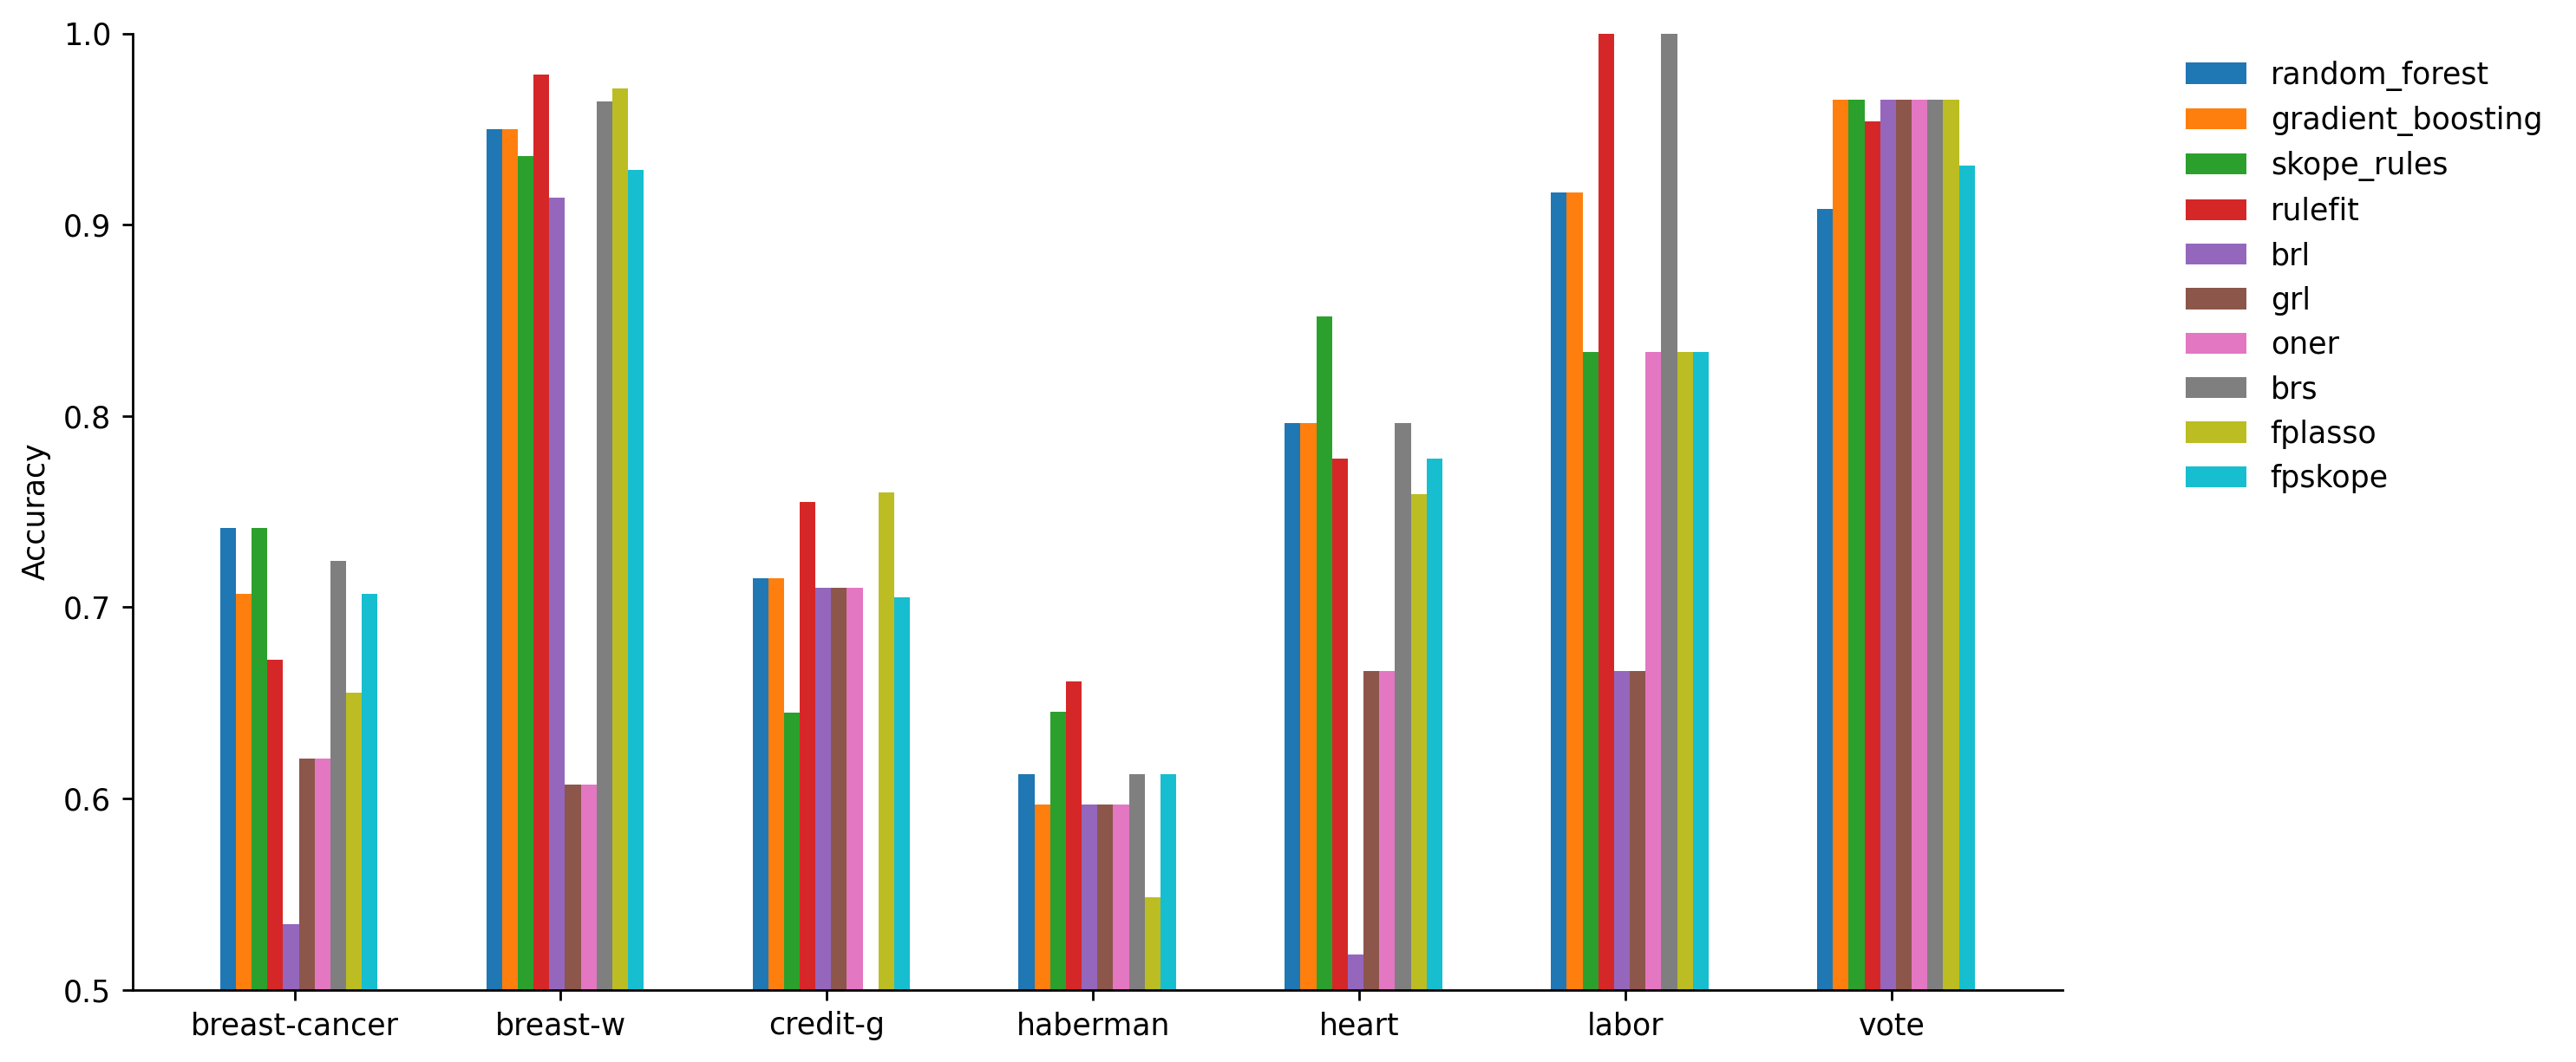

In [8]:
n = len(test_models)
plt.figure(figsize=(12, 5))
for i, m in enumerate(mods):
    acc = accs[m]
    plt.bar(np.arange(len(acc)) + i / (n*1.3), acc, width=1/ (n*1.3), label=m)
plt.xticks(np.arange(len(dsets)) + .25, labels=dsets)
plt.ylabel('Accuracy')
plt.ylim((0.5, 1))
plt.legend(bbox_to_anchor=(1.05, 1), frameon=False)
viz.savefig('acc_across_dsets')

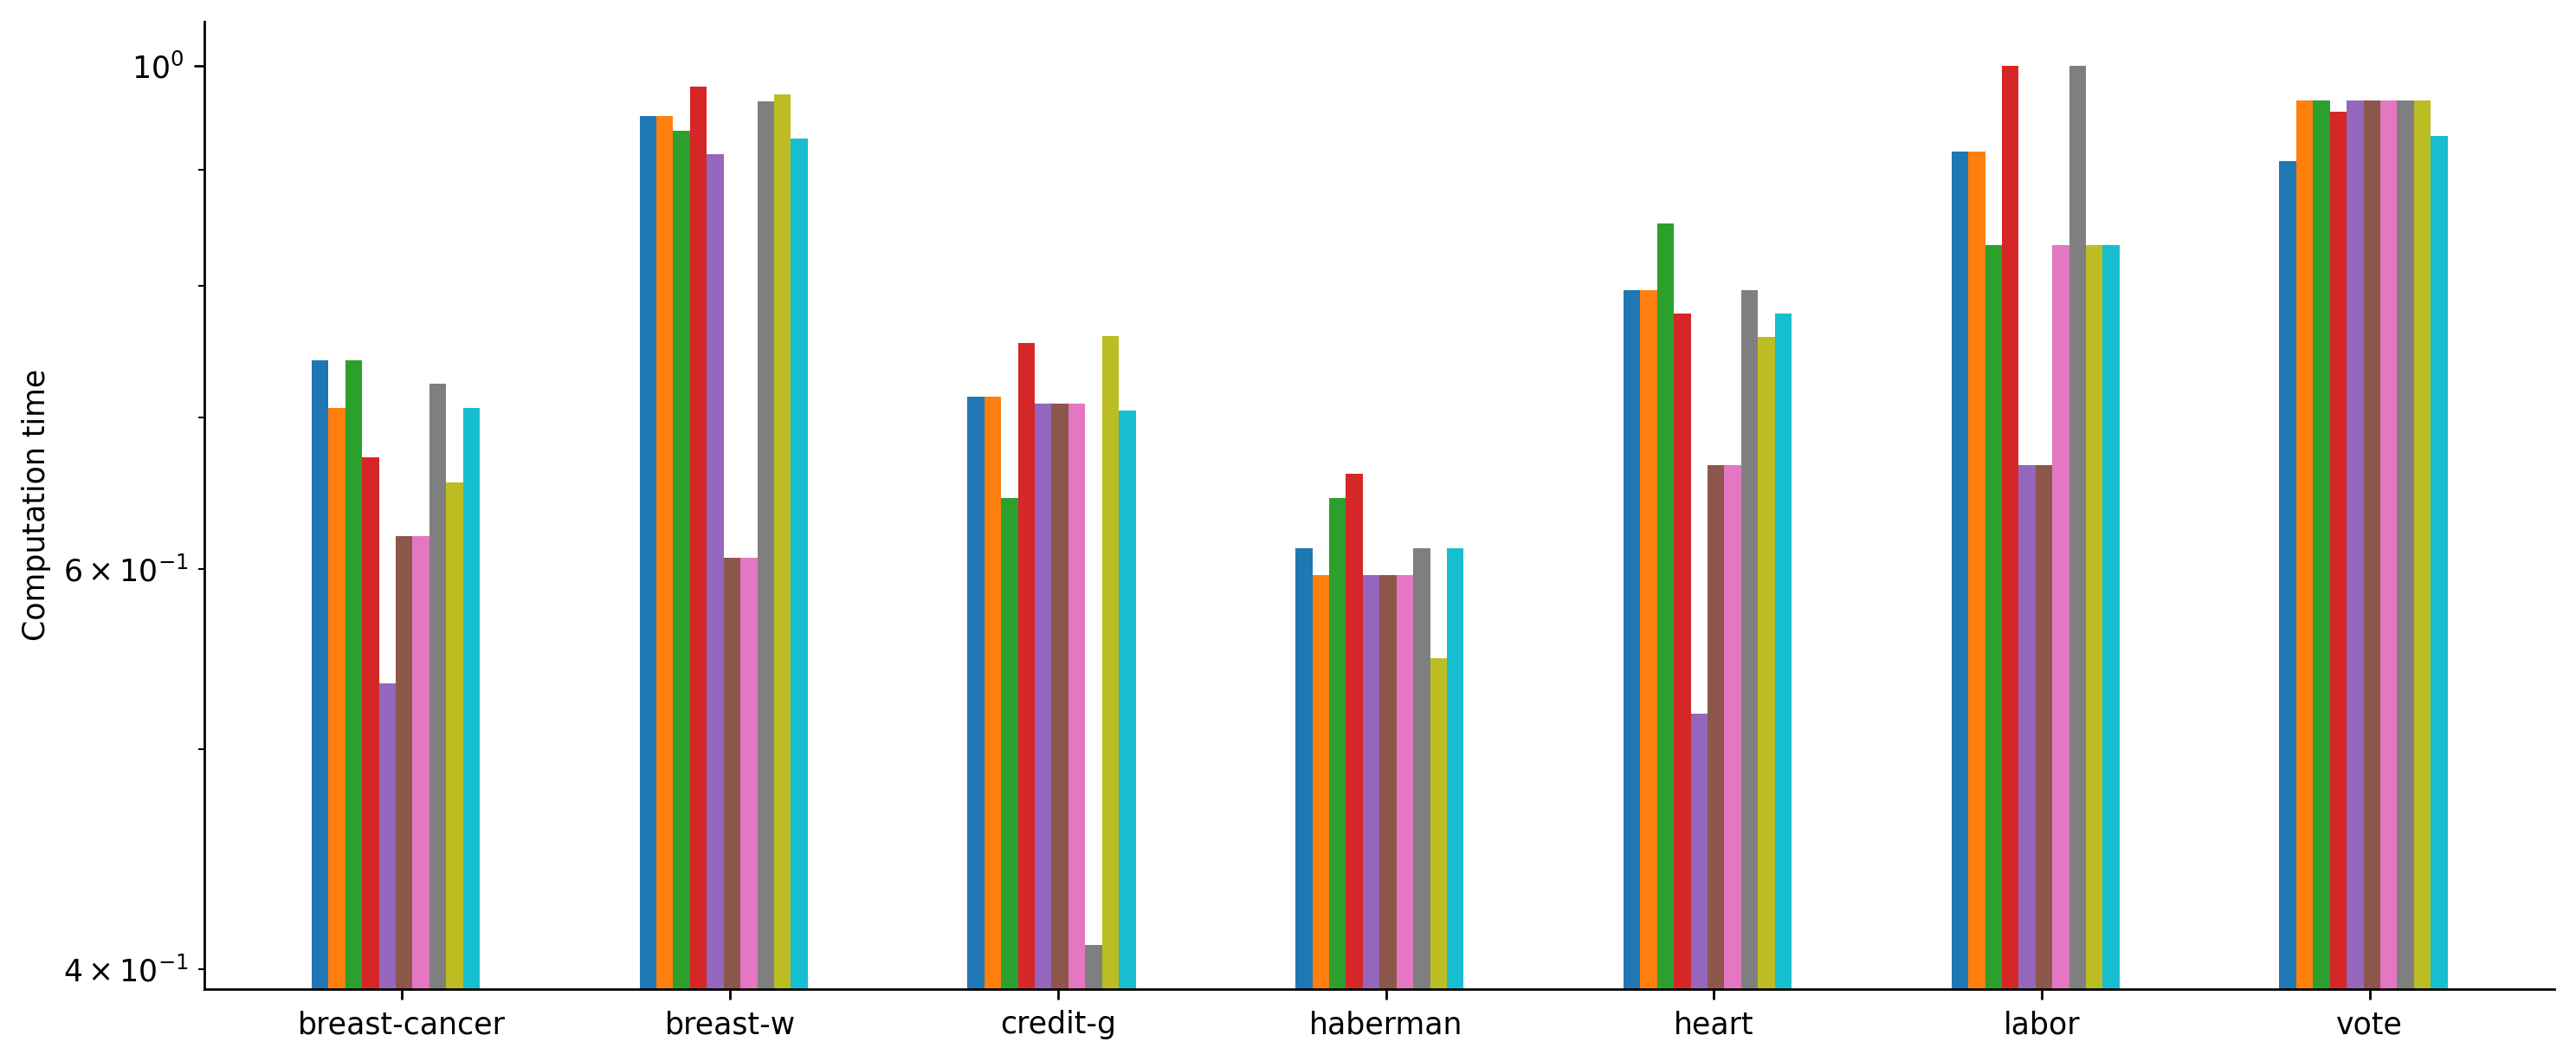

In [9]:
n = len(test_models)
plt.figure(figsize=(12, 5))
for i, m in enumerate(mods):
    acc = accs[m]
    plt.bar(np.arange(len(acc)) + i / (n*1.5), acc, width=1/ (n*1.5), label=m)
plt.xticks(np.arange(len(dsets)) + .25, labels=dsets)
plt.ylabel('Computation time')
plt.yscale('log')
# plt.legend(bbox_to_anchor=(1.05, 1), frameon=False)
viz.savefig('time_across_dsets')